In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [6]:
data_import = pd.read_csv('../Data/LT_DU_data_for_ML_All_variations_optimized_outliers.csv',
usecols=['hourly_rate', 'esize_class_ord', 'gender_M', 'age_class_ord', 'education_ord', 'lpk', 'experience_sc']) # All variations of categorical and numeric transformations
data_import.columns

Index(['lpk', 'hourly_rate', 'esize_class_ord', 'gender_M', 'age_class_ord',
       'education_ord', 'experience_sc'],
      dtype='object')

# Upper part of 'hourly_rate' distribution in lpk groups

In [75]:
data = data_import.copy()

In [76]:
data.shape

(36513, 7)

# Prepare X and y

In [100]:
def observations_below_outlier(df, outlier_threshold=0.95):
    """Select observations, 
    which exceed selected hourly rate 
    percentile threshold within lpk group"""
    df['rank'] = df.groupby('lpk')['hourly_rate'].rank(pct=True).copy()
    df = df.query('rank < @outlier_threshold')
    df = df.drop(columns='rank')     
    return df

In [105]:
threshold = 90

df = observations_below_outlier(data, outlier_threshold=threshold)
print(f'Number of records after removal of outliers,{chr(10)}which exceed {threshold} hourly rate percentile within lpk group:', len(df))

Number of records after removal of outliers,
which exceed 90 hourly rate percentile within lpk group: 36513


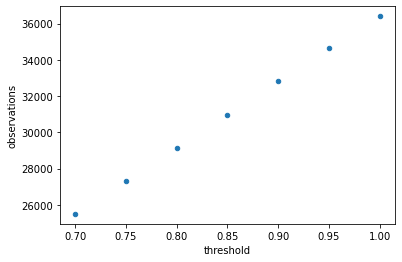

In [119]:
p = []
n = []

for threshold in np.linspace(0.7, 1 ,7):
    n.append(len(observations_below_outlier(data, outlier_threshold=threshold)))
    p.append(threshold)

pd.DataFrame(zip(p, n), columns=['threshold', 'observations']).plot.scatter(x='threshold', y='observations');

# NOT FINISHED
#

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
y_train.shape, y_test.shape, y_train.shape, y_test.shape

((29210,), (7303,))

In [8]:
y_train_mean = np.mean(y_train)
y_train_mean.round(2)

4.72

# Model and predictions

## Initial model

In [9]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X=X_train, y=y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [10]:
print('Train: RMSE=', np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3),
    ' R2=', r2_score(y_train, y_train_pred).round(3))

print('Test: RMSE=', np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3),
    ' R2=', r2_score(y_test, y_test_pred).round(3))

Train: RMSE= 1.44  R2= 0.615
Test: RMSE= 1.487  R2= 0.593


## Best eta, gamma, max_depth

Best eta:  0.133


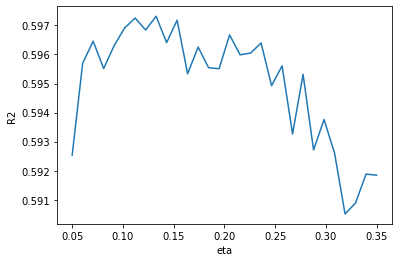

In [11]:
etas = np.linspace(0.05, 0.35, 30)
scores_eta=[]
for eta in etas:
    model = XGBRegressor(eta=eta)
    model.fit(X=X_train,y=y_train)
    score = model.score(X=X_test,y=y_test)
    scores_eta.append(score)

best_eta = round(etas[scores_eta.index(max(scores_eta))],3)
print('Best eta: ', best_eta)

sns.lineplot(x=etas, y=scores_eta)
plt.xlabel('eta')
plt.ylabel('R2');

Best max depth:  6


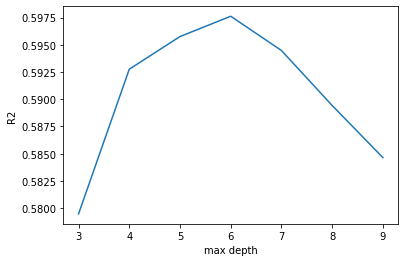

In [12]:
depths = np.arange(3,  10)
scores_depth=[]
for depth in depths:
    model = XGBRegressor(max_depth=depth, eta=best_eta)
    model.fit(X=X_train,y=y_train)
    score = model.score(X=X_test,y=y_test)
    scores_depth.append(score)

best_depth = round(depths[scores_depth.index(max(scores_depth))],3)
print('Best max depth: ', best_depth)

sns.lineplot(x=depths, y=scores_depth)
plt.xlabel('max depth')
plt.ylabel('R2');

Best gamma:  1.947


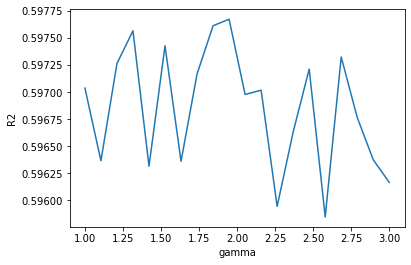

In [13]:
gammas = np.linspace(1,  3, num=20)
scores_gamma=[]
for gamma in gammas:
    model = XGBRegressor(gamma=gamma, eta=best_eta, max_depth=best_depth)
    model.fit(X=X_train,y=y_train)
    score = model.score(X=X_test,y=y_test)
    scores_gamma.append(score)

best_gamma = round(gammas[scores_gamma.index(max(scores_gamma))],3)
print('Best gamma: ', best_gamma)

sns.lineplot(x=gammas, y=scores_gamma)
plt.xlabel('gamma')
plt.ylabel('R2');

In [14]:
model = XGBRegressor(gamma=best_gamma, eta=best_eta, max_depth=best_depth)
model.fit(X=X_train, y=y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
residuals_test=y_test_pred-y_test
r_residuals_test=(y_test_pred-y_test)/y_test*100

In [15]:
print('Train: RMSE=', np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3),
    ' R2=', r2_score(y_train, y_train_pred).round(3))

print('Test: RMSE=', np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3),
    ' R2=', r2_score(y_test, y_test_pred).round(3))

Train: RMSE= 1.465  R2= 0.601
Test: RMSE= 1.48  R2= 0.597
